# Project 4 - Part 2 Twitter Data

Gorkem Camli (105709280)

#### Library imports

In [1]:
import pandas as pd
import json
import pytz
import datetime



import re
import collections
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

#### Explore Data

In [2]:
repo_name = 'ECE219_tweet_data/'
file_names= ['tweets_#gohawks.txt',
             'tweets_#gopatriots.txt',
             'tweets_#nfl.txt',
             'tweets_#patriots.txt',
             'tweets_#sb49.txt',
             'tweets_#superbowl.txt'
]

df_names = []
for file_name in file_names:
    file_name_key = file_name[file_name.find('#')+1: file_name.find('.')]
    df_names.append(file_name_key)

In [3]:
def read_txt_file(fname):
    "takes too long for the last sb49 and superbowl txt files"
    with open(fname) as f:
        lines = f.read().splitlines()

    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']
    df_inter['json_element'].apply(json.loads)
    df_final = pd.json_normalize(df_inter['json_element'].apply(json.loads))    
    return df_final

def read_txt_file2(fname):
    "read line by line and get only what you need for Q27 and Q28"
    df_dict = collections.defaultdict(list)
    with open(fname, 'r') as f:
        for line in f:
            tweet = json.loads(line)
            df_dict['title'].append(tweet['title'])
            df_dict['citation_date'].append(tweet['citation_date'])
            df_dict['retweet_count'].append(tweet['metrics']['citations']['total']) 
            df_dict['followers_count'].append(tweet['author']['followers'])

    df_final = pd.DataFrame(df_dict)
    return df_final

In [4]:
tweet_dfs = {}
for file_name in file_names:
    file_name_key = file_name[file_name.find('#')+1: file_name.find('.')]
    tweet_dfs[file_name_key] = read_txt_file2(fname=repo_name+file_name)
    print(file_name_key, tweet_dfs[file_name_key].shape)
    #display(tweet_dfs[file_name_key].head(3))

gohawks (169122, 4)
gopatriots (23511, 4)
nfl (233022, 4)
patriots (440621, 4)
sb49 (743649, 4)
superbowl (1213813, 4)


### Question 27

__Report the following statistics for each hashtag, i.e. each file.__

• Average number of tweets per hour

• Average number of followers of users posting the tweets per tweet (to make it simple, we average over the number of tweets; if a users posted twice, we count the user and the user’s followers twice as well)

• Average number of retweets per tweet


In [5]:
TIME_ZONE = 'US/Pacific'
PST_TZ = pytz.timezone(TIME_ZONE) # PST time zone 

In [6]:

for df_name in df_names:
    cur_df = tweet_dfs[df_name]
    new_cols = ['citation_date_year', 'citation_date_month','citation_date_day','citation_date_hour']
    cur_df['citation_date_fixed'] = cur_df.citation_date.apply(lambda x:  datetime.datetime.fromtimestamp(x, PST_TZ)) 
    cur_df[new_cols] = cur_df.apply(lambda x: [x['citation_date_fixed'].year, x['citation_date_fixed'].month,
                                               x['citation_date_fixed'].day, x['citation_date_fixed'].hour], axis=1, result_type='expand')
    cur_df['citation_date_rounded_hour']= cur_df.citation_date_fixed.apply(lambda x: x.replace(second=0, microsecond=0, minute=0))
  

In [7]:
def avg_tweet_per_hour(df):
    cols_group = ['citation_date_year', 'citation_date_month','citation_date_day','citation_date_hour']
    return df.groupby(by=cols_group).title.count().mean()

def avg_num_followers(df):
    '''
    Average number of followers of users posting the tweets per tweet 
    (to make it simple, we average over the number of tweets; 
    if a users posted twice, we count the user and the user’s followers twice as well)
    '''
    avg_followers = df['followers_count'].mean()
    return avg_followers

def avg_retweet_per_tweet(df):
    return df['retweet_count'].mean()

In [8]:
for df_name in df_names:
    cur_df = tweet_dfs[df_name]
    
    print(f'\n\n--- Stats for #{df_name} ---')
    avg_twt = avg_tweet_per_hour(cur_df)
    print('Average # tweet per hour', round(avg_twt,3))
    
    avg_flws = avg_num_followers(cur_df)
    print('Average # followers', round(avg_flws,3))
    
    avg_retweet_per_twt = avg_retweet_per_tweet(cur_df)
    print('Average # retweet per tweet', round(avg_retweet_per_twt,3))



--- Stats for #gohawks ---
Average # tweet per hour 296.705
Average # followers 2217.924
Average # retweet per tweet 2.013


--- Stats for #gopatriots ---
Average # tweet per hour 53.313
Average # followers 1427.253
Average # retweet per tweet 1.408


--- Stats for #nfl ---
Average # tweet per hour 399.695
Average # followers 4662.375
Average # retweet per tweet 1.534


--- Stats for #patriots ---
Average # tweet per hour 750.632
Average # followers 3280.464
Average # retweet per tweet 1.785


--- Stats for #sb49 ---
Average # tweet per hour 1384.821
Average # followers 10374.16
Average # retweet per tweet 2.527


--- Stats for #superbowl ---
Average # tweet per hour 2067.825
Average # followers 8814.968
Average # retweet per tweet 2.391


### Question 28

__Plot “number of tweets in hour” over time for #SuperBowl and #NFL (a bar plot with 1-hour bins). The tweets are stored in separate files for different hashtags and files are named as tweet [#hashtag].txt.__

In [9]:
def plot_num_tweet_per_hour(df, df_name, x_ticks_freq=10):
    cols = ['citation_date_rounded_hour']
    gp_df = pd.DataFrame(df.groupby(by=cols).title.count())
    gp_df.sort_index(inplace=True)
    #gp_df.reset_index(inplace=True)
    gp_df.rename(columns={'title':'tweet_count_per_hour'}, inplace=True)
    
    ax = gp_df.plot(kind='bar',figsize=(30,7), rot=90)
    plt.title(f'{df_name} Bar Plot for Number of Tweets in hour over time')
    ax.set_ylabel('Tweet Count Per Hour')
    ax.set_xlabel('Citation Date')
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text()[:-9] for l in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticks(ticks[::x_ticks_freq])
    ax.xaxis.set_ticklabels(ticklabels[::x_ticks_freq])
    plt.show()
    
    


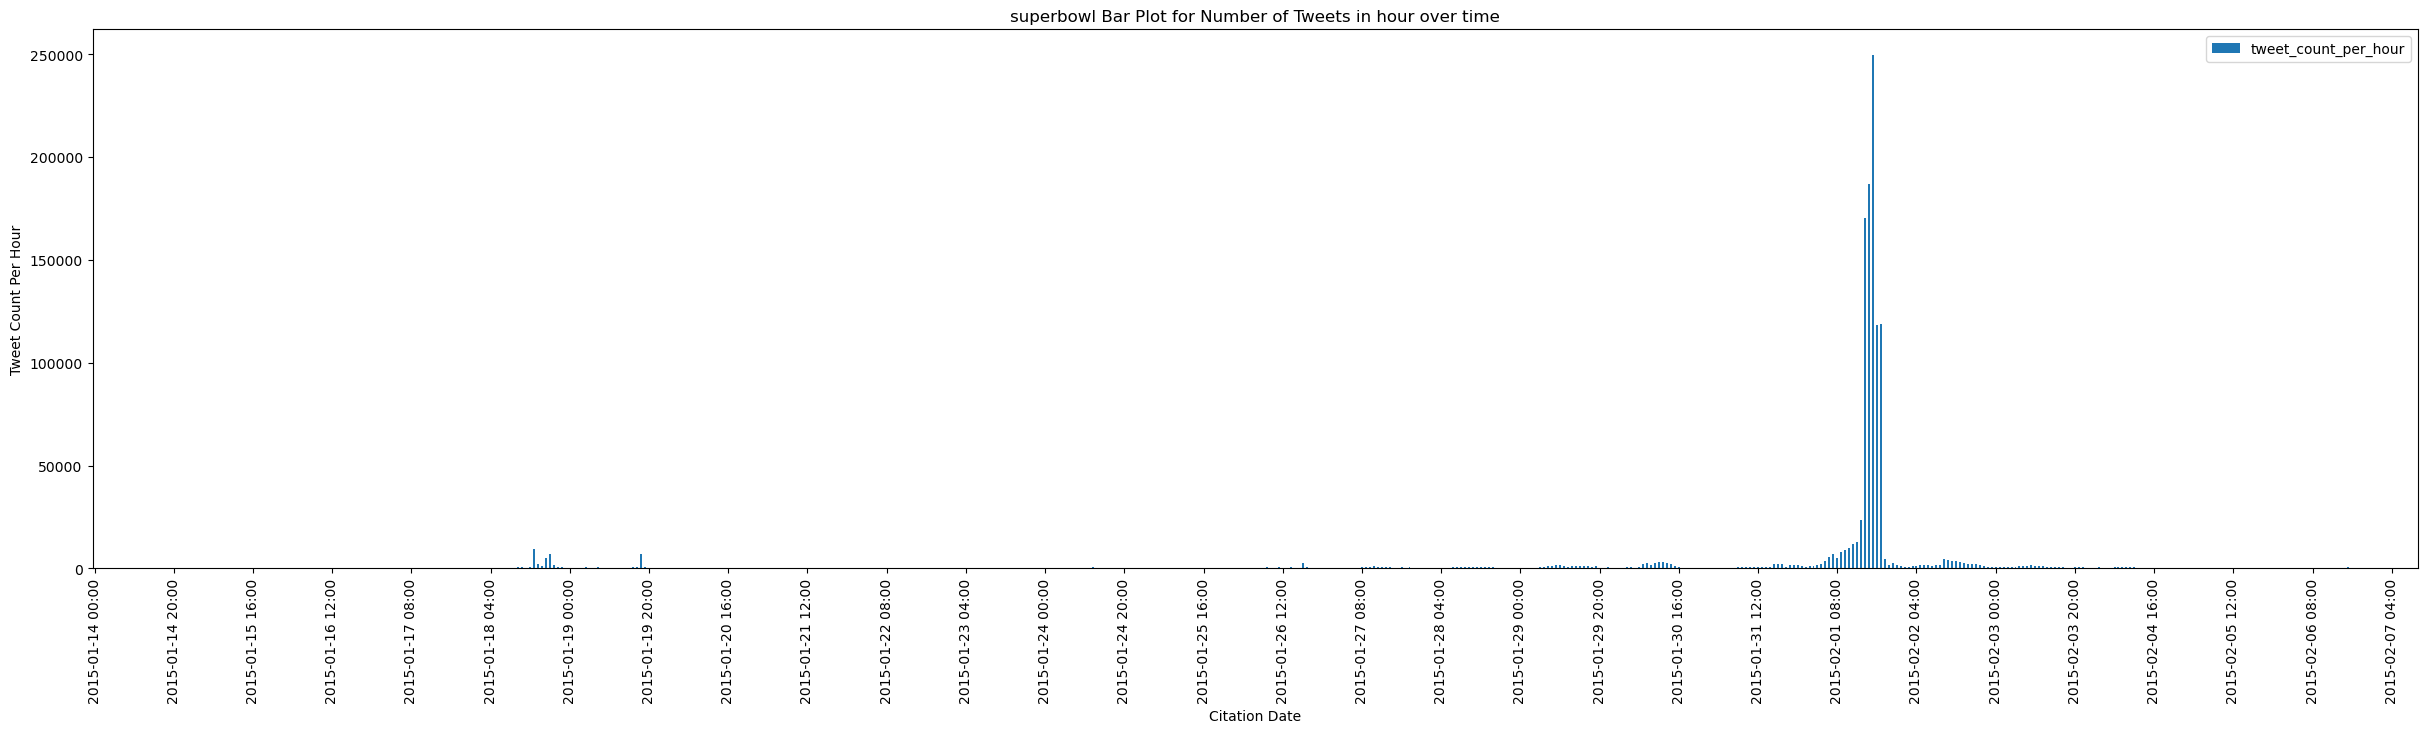

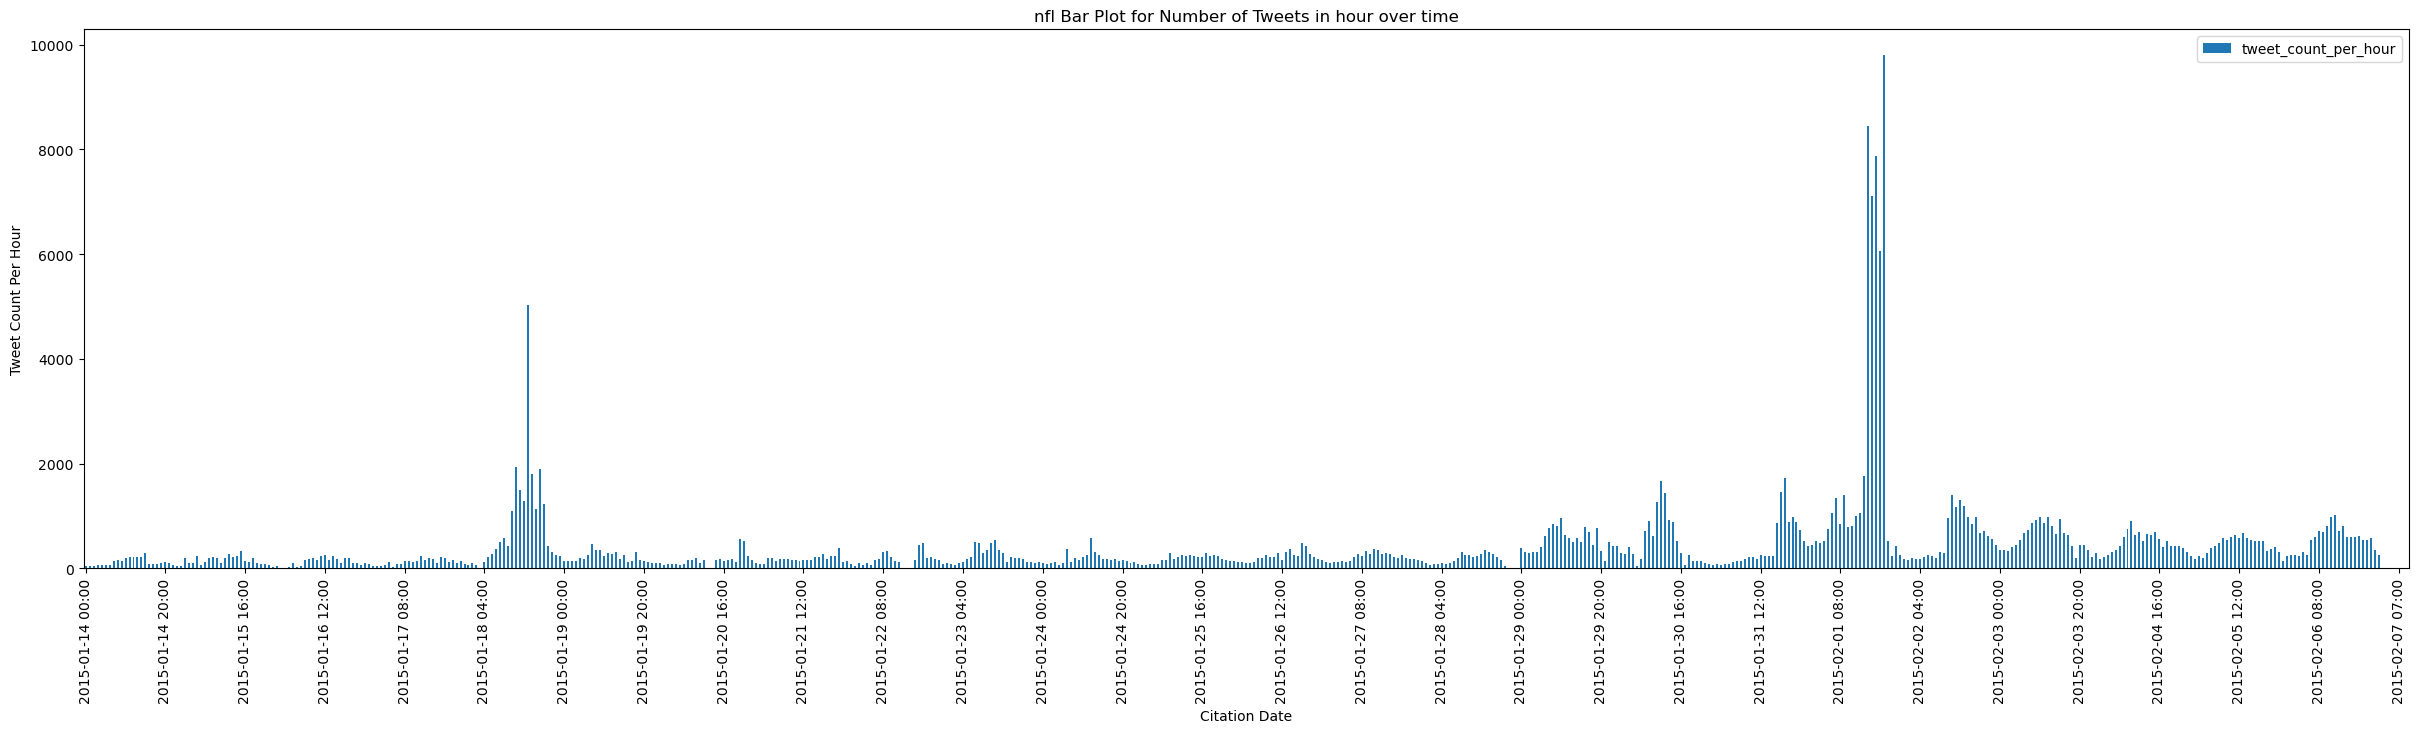

In [10]:
for df_name in ['superbowl','nfl']:
    cur_df = tweet_dfs[df_name]
    plot_num_tweet_per_hour(cur_df, df_name, x_ticks_freq=20)

### Question 29

Follow the steps outlined below: 

- Describe your task.
- Explore the data and any metadata (you can even incorporate additional datasets if you choose).
- Describe the feature engineering process. Implement it with reason: Why are you extracting features this way - why not in any other way?
- Generate baselines for your final ML model.
- A thorough evaluation is necessary.
- Be creative in your task design - use things you have learned in other classes too if you are excited about them!

In [11]:
# set naive datetime correctly
# (Add timezone to a naive datetime) from : https://medium.com/@eleroy/10-things-you-need-to-know-about-date-and-time-in-python-with-datetime-pytz-dateutil-timedelta-309bfbafb3f7

GAME_START = datetime.datetime(2015, 2, 1, 15, 30, 0, 0)
GAME_START = PST_TZ.localize(GAME_START)

GAME_END = datetime.datetime(2015, 2, 1, 19, 6, 0, 0)
GAME_END = PST_TZ.localize(GAME_END)

In [12]:
tweet_dfs2 = {}
for file_name in ['tweets_#gohawks.txt','tweets_#gopatriots.txt']:
    file_name_key = file_name[file_name.find('#')+1: file_name.find('.')]
    tweet_dfs2[file_name_key] = read_txt_file(fname=repo_name+file_name)
    print(file_name_key, tweet_dfs[file_name_key].shape)
    #display(tweet_dfs[file_name_key].head(3))
    
tweet_dfs2['gohawks']['hashtag'] = '#gohawks'
tweet_dfs2['gopatriots']['hashtag'] = '#gopatriots'

gohawks (169122, 10)
gopatriots (23511, 10)


In [13]:
display(pd.DataFrame(tweet_dfs2['gohawks']['tweet.lang'].value_counts(normalize=True)).head(10).T)
display(pd.DataFrame(tweet_dfs2['gopatriots']['tweet.lang'].value_counts(normalize=True)).head(10).T)

,en,und,es,pt,de,fr,ja,tl,in,ht
tweet.lang,0.841801,0.119198,0.011104,0.008976,0.003737,0.001963,0.001904,0.001898,0.001721,0.000987


,en,und,es,pt,de,fr,ht,it,in,tl
tweet.lang,0.547999,0.18234,0.129131,0.089107,0.00906,0.008166,0.005614,0.004211,0.003785,0.003275


In [14]:
cols = ['title', 'tweet.text', 'citation_date','hashtag', 'tweet.lang', 'tweet.user.name', 'author.name','original_author.name']
tweet_emt_df = pd.concat([tweet_dfs2['gohawks'][cols], tweet_dfs2['gopatriots'][cols]])
tweet_emt_df = tweet_emt_df.sort_values(by='citation_date')
tweet_emt_df = tweet_emt_df[tweet_emt_df['tweet.lang']=='en'] # english tweets only
tweet_emt_df

,title,tweet.text,citation_date,hashtag,tweet.lang,tweet.user.name,author.name,original_author.name
205,“@TheDA53: “@nathanSD8: @TheDA53 broncos?! 😢 #...,“@TheDA53: “@nathanSD8: @TheDA53 broncos?! 😢 #...,1421222681,#gohawks,en,Nathan Santo Domingo,Nathan Santo Domingo,Nathan Santo Domingo
203,Dr. Jim Kurtz &amp; I before Seahawks vs Panth...,Dr. Jim Kurtz &amp; I before Seahawks vs Panth...,1421222750,#gohawks,en,Dr Gerry Ramogida,Jenny Carboni,Dr Gerry Ramogida
208,@Trapstar_DJ the more the merrier! #GoHawks,@Trapstar_DJ the more the merrier! #GoHawks,1421223140,#gohawks,en,Will Njuguna,Will Njuguna,Will Njuguna
209,Interview With the Seattle Seahawks Superbowl ...,Interview With the Seattle Seahawks Superbowl ...,1421223224,#gohawks,en,Kim Jackson,Kim Jackson,Kim Jackson
210,@ReyMos85 Keeping Eddy Lacey in check!!! #GoHawks,@ReyMos85 Keeping Eddy Lacey in check!!! #GoHawks,1421223330,#gohawks,en,Amanda Clark,Amanda Clark,Amanda Clark
...,...,...,...,...,...,...,...,...
169118,"#Seahawks all day, everyday!!! #beastmode #LOB...","#Seahawks all day, everyday!!! #beastmode #LOB...",1423291665,#gohawks,en,Charles R,Charles R,Charles R
169119,Interview With the Seattle Seahawks Superbowl ...,Interview With the Seattle Seahawks Superbowl ...,1423295642,#gohawks,en,Kim Jackson,Kim Jackson,Kim Jackson
23510,That’s how you do it. #sb49 #gopatriots,That’s how you do it. #sb49 #gopatriots,1423295675,#gopatriots,en,Steven Evans,Steven Evans,Steven Evans
169120,If you love Russell Wilson and want to know mo...,If you love Russell Wilson and want to know mo...,1423295796,#gohawks,en,/r/Seahawks,/r/Seahawks,/r/Seahawks


In [15]:
print(tweet_emt_df.hashtag.value_counts())
tweet_emt_df.hashtag.value_counts(normalize=True)

#gohawks       142367
#gopatriots     12884
Name: hashtag, dtype: int64


#gohawks       0.917012
#gopatriots    0.082988
Name: hashtag, dtype: float64

In [16]:
# prep posting time
new_cols = ['citation_date_year', 'citation_date_month','citation_date_day','citation_date_hour']
tweet_emt_df['citation_date_fixed'] = tweet_emt_df.citation_date.apply(lambda x:  datetime.datetime.fromtimestamp(x, PST_TZ)) 
tweet_emt_df[new_cols] = tweet_emt_df.apply(lambda x: [x['citation_date_fixed'].year, x['citation_date_fixed'].month,
                                           x['citation_date_fixed'].day, x['citation_date_fixed'].hour], axis=1, result_type='expand')
tweet_emt_df['citation_date_rounded_hour']= tweet_emt_df.citation_date_fixed.apply(lambda x: x.replace(second=0, microsecond=0, minute=0))
tweet_emt_df.head(5)

,title,tweet.text,citation_date,hashtag,tweet.lang,tweet.user.name,author.name,original_author.name,citation_date_fixed,citation_date_year,citation_date_month,citation_date_day,citation_date_hour,citation_date_rounded_hour
205,“@TheDA53: “@nathanSD8: @TheDA53 broncos?! 😢 #...,“@TheDA53: “@nathanSD8: @TheDA53 broncos?! 😢 #...,1421222681,#gohawks,en,Nathan Santo Domingo,Nathan Santo Domingo,Nathan Santo Domingo,2015-01-14 00:04:41-08:00,2015,1,14,0,2015-01-14 00:00:00-08:00
203,Dr. Jim Kurtz &amp; I before Seahawks vs Panth...,Dr. Jim Kurtz &amp; I before Seahawks vs Panth...,1421222750,#gohawks,en,Dr Gerry Ramogida,Jenny Carboni,Dr Gerry Ramogida,2015-01-14 00:05:50-08:00,2015,1,14,0,2015-01-14 00:00:00-08:00
208,@Trapstar_DJ the more the merrier! #GoHawks,@Trapstar_DJ the more the merrier! #GoHawks,1421223140,#gohawks,en,Will Njuguna,Will Njuguna,Will Njuguna,2015-01-14 00:12:20-08:00,2015,1,14,0,2015-01-14 00:00:00-08:00
209,Interview With the Seattle Seahawks Superbowl ...,Interview With the Seattle Seahawks Superbowl ...,1421223224,#gohawks,en,Kim Jackson,Kim Jackson,Kim Jackson,2015-01-14 00:13:44-08:00,2015,1,14,0,2015-01-14 00:00:00-08:00
210,@ReyMos85 Keeping Eddy Lacey in check!!! #GoHawks,@ReyMos85 Keeping Eddy Lacey in check!!! #GoHawks,1421223330,#gohawks,en,Amanda Clark,Amanda Clark,Amanda Clark,2015-01-14 00:15:30-08:00,2015,1,14,0,2015-01-14 00:00:00-08:00


### get players positions data

In [17]:
players_df = pd.read_csv('sb 49 - players.csv')
display(players_df.head(10).T)

positions_df = pd.read_csv('sb 49 - positions.csv')
display(positions_df.head(10).T)

player_df = players_df.merge(positions_df, left_on='Pos', right_on='Abbreviation' , how='left')
display(player_df.sample(10).T)

,0,1,2,3,4,5,6,7,8,9
Player,Tom Brady,Shane Vereen,Brandon LaFell,Julian Edelman,Rob Gronkowski,Michael Hoomanawanui,Nate Solder,Dan Connolly,Bryan Stork,Ryan Wendell
Pos,QB,RB,WR,WR,TE,TE,LT,LG,C,RG
Team,Patriots,Patriots,Patriots,Patriots,Patriots,Patriots,Patriots,Patriots,Patriots,Patriots


,0,1,2,3,4,5,6,7,8,9
Abbreviation,QB,RB,FB,TB,HB,OL,G,LG,RG,T
Position,Quarterback,Running Back,Full Back,Tail Back,Half Back,Offensive Line,Guard,Left Guard,Right Guard,Tackle
Category,Offense,Offense,Offense,Offense,Offense,Offense,Offense,Offense,Offense,Offense


,35,36,41,2,43,23,13,40,5,10
Player,Kevin Williams,Cliff Avril,Byron Maxwell,Brandon LaFell,Earl Thomas,Marshawn Lynch,Sealver Siliga,Richard Sherman,Michael Hoomanawanui,Sebastian Vollmer
Pos,RDT,RDE,RCB,WR,FS,RB,DT,LCB,TE,RT
Team,Seahawks,Seahawks,Seahawks,Patriots,Seahawks,Seahawks,Patriots,Seahawks,Patriots,Patriots
Abbreviation,RDT,RDE,RCB,WR,FS,RB,DT,LCB,TE,RT
Position,Right Defensive Tackle,Right Defensive End,Right Cornerback,Wide Receiver,Free Safety,Running Back,Defensive Tackle,Left Cornerback,Tight End,Right Tackle
Category,Defense,Defense,Defense,Offense,Defense,Offense,Defense,Defense,Offense,Offense


players data: https://www.pro-football-reference.com/boxscores/201502010sea.htm#all_team_stats

positions data: https://www.rookieroad.com/football/positions/position-abbreviations/

In [18]:
players_df['player_first_name'] = players_df.Player.apply(lambda x: x.split(' ')[0])
players_df['player_last_name']= players_df.Player.apply(lambda x: x.split(' ')[-1])

In [19]:
players_df.groupby(by=['Team','Player','player_first_name']).count()

Pos  player_last_name
Team     Player               player_first_name                       
Patriots Brandon Browner      Brandon              1                 1
         Brandon LaFell       Brandon              1                 1
         Bryan Stork          Bryan                1                 1
         Chandler Jones       Chandler             1                 1
         Dan Connolly         Dan                  1                 1
         Darrelle Revis       Darrelle             1                 1
         Devin McCourty       Devin                1                 1
         Dont'a Hightower     Dont'a               1                 1
         Jamie Collins        Jamie                1                 1
         Julian Edelman       Julian               1                 1
         Kyle Arrington       Kyle                 1                 1
         Michael Hoomanawanui Michael              1                 1
         Nate Solder          Nate                 1                 1
         Patrick Chung        Patrick              1                 1
         Rob Gronkowski       Rob                  1                 1
         Rob Ninkovich        Rob                  1                 1
         Ryan Wendell         Ryan                 1                 1
         Sealver Siliga       Sealver              1                 1
         Sebastian Vollmer    Sebastian            1                 1
         Shane Vereen         Shane                1                 1
         Tom Brady            Tom                  1                 1
         Vince Wilfork        Vince                1                 1
Seahawks Bobby Wagner         Bobby                1                 1
         Bruce Irvin          Bruce                1                 1
         Byron Maxwell        Byron                1                 1
         Cliff Avril          Cliff                1                 1
         Doug Baldwin         Doug                 1                 1
         Earl Thomas          Earl                 1                 1
         J.R. Sweezy          J.R.                 1                 1
         James Carpenter      James                1                 1
         Jermaine Kearse      Jermaine             1                 1
         Justin Britt         Justin               1                 1
         K.J. Wright          K.J.                 1                 1
         Kam Chancellor       Kam                  1                 1
         Kevin Williams       Kevin                1                 1
         Luke Willson         Luke                 1                 1
         Marshawn Lynch       Marshawn             1                 1
         Max Unger            Max                  1                 1
         Michael Bennett      Michael              1                 1
         Ricardo Lockette     Ricardo              1                 1
         Richard Sherman      Richard              1                 1
         Russell Okung        Russell              1                 1
         Russell Wilson       Russell              1                 1
         Tony McDaniel        Tony                 1                 1

Important first steps:

Extra data collection:
    - Finding players data for each team
    - 
    
Assign tweet times to game time:
    - pre, during, after game
    - quarter and quarter time.
    
Game start time: 6:30  (3:30 PCT time)
time of game: 3:36


### find players mentioned for each tweet

In [20]:
# find players for each tweet 

def find_players_listed_in_tweet(tweet):
    players = []
    tweet_lower = tweet.lower()
    for player in list(players_df.Player.unique()):
        player_lower = player.lower()
        player_first, player_last = player_lower.split(' ')[0], player_lower.split(' ')[-1]
        
        if player_lower in tweet_lower or player_first in tweet_lower or player_last in tweet_lower:
            players.append(player)
    return None if not players else players

tweet_emt_df['player'] = tweet_emt_df['tweet.text'].apply(lambda x: find_players_listed_in_tweet(tweet=x))
tweet_emt_df['player_count'] = tweet_emt_df['player'].apply(lambda x: 0 if not x else len(x))
tweet_emt_df['players_str'] = tweet_emt_df['player'].apply(lambda x: ', '.join(x) if x else '')

In [21]:
tweet_emt_df['player_count'].value_counts()

0     124706
1      20286
2       8253
3       1482
4        356
5        106
6         44
7         13
8          3
12         1
11         1
Name: player_count, dtype: int64

In [22]:
dd = pd.DataFrame(tweet_emt_df.groupby(by=['players_str']).title.count())
dd = dd.sort_values(by='title', ascending=False)
dd.head(50)

,title
players_str,
,124706
Tom Brady,4545
"Dan Connolly, Russell Wilson",3710
Marshawn Lynch,3393
Richard Sherman,2691
"Russell Wilson, Russell Okung",1526
Doug Baldwin,1207
Earl Thomas,1116
Dan Connolly,1080


In [23]:
dd.describe()

,title
count,667.00000
mean,232.76012
std,4836.56560
min,1.00000
25%,1.00000
50%,1.00000
75%,5.00000
max,124706.00000


### find time intervals of the game

In [24]:
def game_interval(twt_time):

    if twt_time < GAME_START :
        return 'pre_game'
    elif GAME_START < twt_time < GAME_END:
        return 'during_game'
    else:
        return 'after_game'
    
def game_interval2(twt_time):

    half_time_start = datetime.datetime(2015, 2, 1, 17, 0, 0, 0, PST_TZ)
    half_time_end = datetime.datetime(2015, 2, 1, 17, 15, 0, 0, PST_TZ)
    
    if twt_time < GAME_START :
        return 'pre_game'
    elif GAME_START < twt_time < half_time_start:
        return 'first_half'
    elif half_time_start < twt_time < half_time_end:
        return 'half_time_show'
    elif half_time_end < twt_time < GAME_END:
        return 'second_half'
    else:
        return 'after_game'
    
tweet_emt_df['game_status'] = tweet_emt_df['citation_date_fixed'].apply(lambda x: game_interval(twt_time=x) )
tweet_emt_df['game_status_detailed'] = tweet_emt_df['citation_date_fixed'].apply(lambda x: game_interval2(twt_time=x) )

In [25]:
tweet_emt_df.game_status.value_counts()

pre_game       117234
during_game     28305
after_game       9712
Name: game_status, dtype: int64

In [26]:
tweet_emt_df.groupby(by=['hashtag', 'game_status']).title.count()

hashtag      game_status
#gohawks     after_game       7761
             during_game     23706
             pre_game       110900
#gopatriots  after_game       1951
             during_game      4599
             pre_game         6334
Name: title, dtype: int64

In [27]:
tweet_emt_df.groupby(by=['hashtag', 'game_status_detailed']).title.count()

hashtag      game_status_detailed
#gohawks     after_game                7765
             first_half                8605
             half_time_show            3213
             pre_game                110900
             second_half              11884
#gopatriots  after_game                1951
             first_half                2206
             half_time_show             254
             pre_game                  6334
             second_half               2139
Name: title, dtype: int64

In [28]:
#dfx = tweet_emt_df[tweet_emt_df['player_count']==1]
#tweet_emt_df.groupby(by=['game_status', 'hashtag','player_count']).title.count()

In [29]:
ht = tweet_dfs['superbowl'][tweet_dfs['superbowl'].title.str.contains('halftime')]
print(ht.shape)
ht.sample(10)

(29193, 10)


,title,citation_date,retweet_count,followers_count,citation_date_fixed,citation_date_year,citation_date_month,citation_date_day,citation_date_hour,citation_date_rounded_hour
807659,What a halftime show by Katy Perry! One for th...,1422840820,1,9072.0,2015-02-01 17:33:40-08:00,2015,2,1,17,2015-02-01 17:00:00-08:00
849411,Was Katy Perry playing with her Wii before the...,1422841739,1,608.0,2015-02-01 17:48:59-08:00,2015,2,1,17,2015-02-01 17:00:00-08:00
221979,"Looking forward to the food, #commercials and ...",1422819446,1,408.0,2015-02-01 11:37:26-08:00,2015,2,1,11,2015-02-01 11:00:00-08:00
615750,"Super Bowl dinner we're ready for halftime, le...",1422838413,1,78.0,2015-02-01 16:53:33-08:00,2015,2,1,16,2015-02-01 16:00:00-08:00
823348,@funnyordie: Katy Perry rocking the Wii safet...,1422841129,1,260.0,2015-02-01 17:38:49-08:00,2015,2,1,17,2015-02-01 17:00:00-08:00
1204832,Six Laser Hair-Removal Treatments in Franklin ...,1423155113,1,236.0,2015-02-05 08:51:53-08:00,2015,2,5,8,2015-02-05 08:00:00-08:00
694368,Not watching halftime show cause I watch Super...,1422839667,1,563.0,2015-02-01 17:14:27-08:00,2015,2,1,17,2015-02-01 17:00:00-08:00
800055,"""@Dewaynne_: @JColeNC need be in the halftime ...",1422840688,2,454.0,2015-02-01 17:31:28-08:00,2015,2,1,17,2015-02-01 17:00:00-08:00
772509,DAMN.\n\nCoolest #SuperBowl halftime show EVAR???,1422840340,1,2476.0,2015-02-01 17:25:40-08:00,2015,2,1,17,2015-02-01 17:00:00-08:00
795327,Glad I'm not on LSD after watching that halfti...,1422840604,1,77.0,2015-02-01 17:30:04-08:00,2015,2,1,17,2015-02-01 17:00:00-08:00


In [30]:
# find the relative time frames for each quarter
quarter_strs = ['first quarter|1st quarter','second quarter|2nd quarter', 'third quarter|3rd quarter', 'fourth quarter|4th quarter']
cs = ['title','citation_date_fixed', 'author.name','tweet.user.name', 'original_author.name']

for qs in quarter_strs:
    display(tweet_emt_df[(tweet_emt_df['tweet.text'].str.contains('end of')) &
                (tweet_emt_df['tweet.text'].str.contains(qs)) &
                (tweet_emt_df['citation_date_fixed']> GAME_START)][cs])

,title,citation_date_fixed,author.name,tweet.user.name,original_author.name
135879,At the end off the first quarter yhe score is ...,2015-02-01 15:59:25-08:00,Nikola SokoloviÄ,Nikola SokoloviÄ,Nikola SokoloviÄ
135974,And that’s the end of the 1st quarter. 0-0 #Se...,2015-02-01 16:00:28-08:00,KIRO Radio 97.3 FM,KIRO Radio 97.3 FM,KIRO Radio 97.3 FM
135972,And that’s the end of the 1st quarter. 0-0 #Se...,2015-02-01 16:00:28-08:00,MyNorthwest.com,MyNorthwest.com,MyNorthwest.com
137016,I lasted until the end of the 1st quarter unti...,2015-02-01 16:13:03-08:00,Craig Goodrum,Craig Goodrum,Craig Goodrum


,title,citation_date_fixed,author.name,tweet.user.name,original_author.name
146119,@DJAelita @TheFaithBreaker 14 - 14 at the end ...,2015-02-01 17:09:09-08:00,Cameron Aubernon,Cameron Aubernon,Cameron Aubernon
167393,Last play last nite was a bad call cuz it didn...,2015-02-02 07:33:55-08:00,Nina,Nina,Nina


,title,citation_date_fixed,author.name,tweet.user.name,original_author.name
155209,24-14 at the end of 3rd quarter. Seahawks lead...,2015-02-01 18:18:37-08:00,sportsupdatez,masonfinchum25@gmail,sportsupdatez


,title,citation_date_fixed,author.name,tweet.user.name,original_author.name
157606,Made it just for the end of the fourth quarter...,2015-02-01 18:48:30-08:00,Nathan Voller,Nathan Voller,Nathan Voller
158797,Coming from behind in end of 4th quarter is wh...,2015-02-01 18:53:28-08:00,Dean Zelikovsky,Dean Zelikovsky,Dean Zelikovsky
167012,"So... Yes, stupid call at the end of the game....",2015-02-02 05:23:54-08:00,Mark the Overseer,Mark the Overseer,Mark the Overseer


In [31]:
# estimate halftime show start and end times
expected_halftime_show_time = datetime.datetime(2015, 2, 1, 17, 12, 0, 0, PST_TZ)
expected_halftime_show_time_end = datetime.datetime(2015, 2, 1, 17, 27, 0, 0, PST_TZ)

res = tweet_emt_df[((tweet_emt_df['tweet.text'].str.contains('halftime')) |
                (tweet_emt_df['tweet.text'].str.contains('Katty Perry|@kattyperry|katty'))) &
                (expected_halftime_show_time_end > tweet_emt_df['citation_date_fixed']) &
                 ( tweet_emt_df['citation_date_fixed'] > expected_halftime_show_time)][['title','citation_date_fixed']]

display(res.head(10))
display(res.tail(10))

,title,citation_date_fixed
15738,Well it's halftime and the game is tied at 14 ...,2015-02-01 17:05:09-08:00
145530,so i catch the game shortly before halftime. ...,2015-02-01 17:05:10-08:00
145584,That's how you go to halftime. 💙💚 #GoHawks,2015-02-01 17:05:28-08:00
145598,Tied at halftime. That's bad news for the Patr...,2015-02-01 17:05:34-08:00
145668,YES!!! @Seahawks TOUCHDOWN!!! NE 14 - SEA 14 a...,2015-02-01 17:05:59-08:00
145685,"Shit, I knew it would be close, but this is su...",2015-02-01 17:06:02-08:00
145691,Forget pizza and wings. This is how we do half...,2015-02-01 17:06:04-08:00
145697,Let see how we adjust at halftime. We didn't n...,2015-02-01 17:06:07-08:00
145718,Whew! Tuned in just in time for the @katyperry...,2015-02-01 17:06:15-08:00
145749,Bear and I took a walk during halftime!! It wa...,2015-02-01 17:06:29-08:00


,title,citation_date_fixed
146739,My 2 and 4 year old's commentary on this halft...,2015-02-01 17:18:07-08:00
146760,#SB49 halftime show is not @katyperry but the ...,2015-02-01 17:18:34-08:00
16051,Bad ass halftime show! @katyperry @pepsi #SBXL...,2015-02-01 17:18:39-08:00
146765,So far my favorite halftime show ever. #katype...,2015-02-01 17:18:40-08:00
146773,Loving the halftime #GoHawks,2015-02-01 17:18:50-08:00
146777,I'm quite enjoying KP halftime show\n\n#GoHawks,2015-02-01 17:18:55-08:00
146781,This halftime show is so damn good! Katy Perry...,2015-02-01 17:18:59-08:00
16057,You're gonna hear me ROAR katyperry #katyperry...,2015-02-01 17:19:20-08:00
146800,I'm so glad Katy Perry is doing halftime... Be...,2015-02-01 17:19:35-08:00
146809,@katyperry @LennyKravitz Awesome halftime show...,2015-02-01 17:19:46-08:00


In [32]:
display(tweet_emt_df[(tweet_emt_df['tweet.text'].str.contains('halftime')) &
                (tweet_emt_df['tweet.text'].str.contains('start')) &
                (tweet_emt_df['citation_date_fixed']> GAME_START)].title.tolist())

["Ok I'm over the halftime show already and It have not ever started yet I want to see the second half of the game #GoPatriots",
 "A halftime tie and the ball the start the 2nd half.  I'll take that.  #GoHawks #RePete — watching Super Bowl XLIX",
 "LOB and the @Seahawks D gets to rest because of the long halftime... It's not how you start, it's how you finish #GoHawks",
 'so i catch the game shortly before halftime.  looks like a new game just started haha.  feels like a regular season game.  #gohawks',
 "Hey NBC halftime crew, here's a news flash! Seattle gets the ball to start 3rd, has momentum, and is the best 2nd half team in NFL.#GoHawks",
 'LOL #KatyPerry started the halftime show with the song that represents the #12s! Love this! #Q13FOX #SB49 #GoHawks #SeahawksWIN',
 'This game just started https://t.co/InXdNG8TMZ #SB49 #halftime #SuperBowl #SuperBowlXLIX #KatyPerrySuperBowl #updownvideos #GoHawks #GoPats']

In [33]:


first_qt_start = GAME_START
first_qt_end = datetime.datetime(2015, 2, 1, 16, 0, 0, 0, PST_TZ)
second_qt_start = first_qt_end
second_qt_end = datetime.datetime(2015, 2, 1, 17, 12, 0, 0, PST_TZ)

#half_time_start = second_qt_end #datetime.datetime(2015, 2, 1, 17, 0, 0, 0, PST_TZ)
#half_time_end = datetime.datetime(2015, 2, 1, 17, 30, 0, 0, PST_TZ)
half_time_start = datetime.datetime(2015, 2, 1, 17, 12, 0, 0, PST_TZ)
half_time_end = datetime.datetime(2015, 2, 1, 17, 27, 0, 0, PST_TZ)

third_qt_start = half_time_end
third_qt_end = datetime.datetime(2015, 2, 1, 18, 18, 0, 0, PST_TZ)

fourth_qt_start = third_qt_end
fourth_qt_end = GAME_END


To assign time frames:
- find online nothing relative to real timeframe like PST, UTC, all the data relative to within quarters
- I tried to found official accounts for Seattle Seahawks and Patriots but the tweets form there limited and you can infer the quarter beginning & end times.

In [34]:
print('\n\nSeattle Seahawks', tweet_emt_df[tweet_emt_df['original_author.name']=='Seattle Seahawks'].shape)
print(list(tweet_emt_df[tweet_emt_df['original_author.name']=='Seattle Seahawks'].title))

print('\n\nNew England Patriots',tweet_emt_df[tweet_emt_df['original_author.name']=='New England Patriots'].shape)
print(list(tweet_emt_df[tweet_emt_df['original_author.name']=='New England Patriots'].title))



Seattle Seahawks (34, 19)
['@Lacer10 #GoHawks Shane!', 'Wilson: #GoHawks', 'Fine #Hawkitecture art! RT @iheartSAM: SAM is IN! @Seahawks #ImIn #HammeringMan #Seattle  #GoHawks #CARvsSEA http://t.co/x9lWHuKp8l', 'Getting ready for the rematch... #GoHawks http://t.co/Cr1OwxBwfq', 'Update: Byron Maxwell did practice today. Pete Carroll says he is good to go and ready to play on Sunday. #GoHawks http://t.co/WoIiZF4z1g', 'The pine-cone curtain is in! RT @gobucs: No doubt about it @Seahawks. We are in! #ImIn #GoHawks #Pirate12s http://t.co/tkN2XEF9Fv', "The @woodlandparkzoo says 'you're welcome' and #GoHawks.\n\nPHOTOS http://t.co/7iqF8DhbFe\n\n#NFLPLayoffs http://t.co/nIh4pjlIzD", "Some numbers for ya. Goodnight 12's... #GoHawks http://t.co/nIVt5FpzSc", "@connor_gaydos @Jenn_Elizabeth0 @ethanjwelch I'm calling bs on this fake fan. #GoHawks", 'Wilson: #GoHawks', '@robmckenna Yeah. #GoHawks', '@Seahawks @PeteCarroll Lifelong Hawk fan all the way in AR. #GoHawks http://t.co/ZmTHKnW4fu', '#Sea

- based on emotions for players (or fans) which team is winnnig the game timeseries prediction.
- based on emotions shown players & polarity can you tell the tweet reactions (reweeet count/fav count) (prediction of retweets throughout game). timeseries prediction too.


# Sentiment Analysis nltk

In [35]:
import nltk

nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/gorkemcamli/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [36]:
def assign_nltk_sentiment_label(compound):
    # reference: https://github.com/cjhutto/vaderSentiment#about-the-scoring
    label=None
    if compound >= 0.05:
        label='positive'
    elif (compound > -0.05) & (compound <0.05):
        label='neutral'
    else:
        label='negative'
    return label

In [37]:
sia = SentimentIntensityAnalyzer()

prefix ='sent_nltk_vader_'
col_names = [prefix+'neg', prefix+'neu',prefix+'pos',prefix+'compound']

tweet_emt_df[col_names] = tweet_emt_df['title'].apply(lambda x: pd.Series(sia.polarity_scores(x)))
tweet_emt_df['sent_nltk_vader_label'] =  tweet_emt_df['sent_nltk_vader_compound'].apply(lambda x: assign_nltk_sentiment_label(x))

In [38]:
tweet_emt_df.sent_nltk_vader_label.value_counts(normalize=True)

positive    0.464699
neutral     0.405833
negative    0.129468
Name: sent_nltk_vader_label, dtype: float64

__TextBlob sentiment__

In [40]:
from textblob import TextBlob

In [41]:
prefix ='sent_textblob_'
col_names = [prefix+'polarity', prefix+'subjectivity']

tweet_emt_df[col_names] = tweet_emt_df['title'].apply(lambda x: pd.Series(TextBlob(x).sentiment))
tweet_emt_df[prefix+'label'] =  tweet_emt_df[prefix+'polarity'].apply(lambda x: assign_nltk_sentiment_label(x))

In [63]:
sentiment_feature = 'sent_textblob_polarity' #sent_nltk_vader_compound
round_num = 2
time_interval_feature = f'post_time_{round_num}_intervals' #post_time_2_intervals


__Roberta sentiment__

In [100]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request


In [101]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)


Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [102]:
# sample roberta usage
text = "Good night 😊"
text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = labels[ranking[i]]
    s = scores[ranking[i]]
    #print(f"{i+1}) {l} {np.round(float(s), 4)}")

In [108]:
from tqdm import tqdm

tqdm.pandas()

In [109]:
def apply_roberta(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return pd.Series(scores)

prefix ='sent_roberta_'
col_names = [prefix+'neg', prefix+'neut', prefix+'pos']

#tweet_emt_df[col_names] = tweet_emt_df['title'].apply(lambda x: apply_roberta(text=x))
tweet_emt_df[col_names] = tweet_emt_df['title'].progress_apply(lambda x: apply_roberta(text=x))
tweet_emt_df[prefix+'label'] =  tweet_emt_df[prefix+'pos'] #.apply(lambda x: assign_nltk_sentiment_label(x))

  0%|          | 499/155251 [00:53<4:35:55,  9.35it/s]


KeyboardInterrupt: 

In [ ]:
# save all sentiments as data frame.

In [64]:
def timeround(tm, round_val=10):
    tm += datetime.timedelta(minutes=int(round_val/2))
    tm -= datetime.timedelta(minutes=tm.minute % round_val,
                             seconds=tm.second,
                             microseconds=tm.microsecond)
    return tm


tweet_emt_df[time_interval_feature] = tweet_emt_df['citation_date_fixed'].apply(lambda x: timeround(x, round_val=round_num))
tweet_emt_df[['citation_date_fixed', time_interval_feature]].head(5)

,citation_date_fixed,post_time_2_intervals
205,2015-01-14 00:04:41-08:00,2015-01-14 00:04:00-08:00
203,2015-01-14 00:05:50-08:00,2015-01-14 00:06:00-08:00
208,2015-01-14 00:12:20-08:00,2015-01-14 00:12:00-08:00
209,2015-01-14 00:13:44-08:00,2015-01-14 00:14:00-08:00
210,2015-01-14 00:15:30-08:00,2015-01-14 00:16:00-08:00


In [65]:
sub_df = tweet_emt_df[(tweet_emt_df.citation_date_month==2) &
                     (tweet_emt_df.citation_date_day==1)] #[tweet_emt_df.game_status=='during_game']
fan_sentiments_df = pd.DataFrame(sub_df.groupby(by=[time_interval_feature,'hashtag'])[sentiment_feature].mean())
fan_sentiments_df.reset_index(inplace=True)
fan_sentiments_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
post_time_2_intervals,2015-02-01 00:00:00-08:00,2015-02-01 00:02:00-08:00,2015-02-01 00:04:00-08:00,2015-02-01 00:06:00-08:00,2015-02-01 00:08:00-08:00,2015-02-01 00:10:00-08:00,2015-02-01 00:12:00-08:00,2015-02-01 00:14:00-08:00,2015-02-01 00:16:00-08:00,2015-02-01 00:22:00-08:00
hashtag,#gohawks,#gohawks,#gohawks,#gohawks,#gohawks,#gohawks,#gohawks,#gohawks,#gohawks,#gohawks
sent_textblob_polarity,0.197309,-0.0101157,0.0266667,0.110958,0.124392,0,0.0694444,-0.015625,0,0.1875


#### plots

<AxesSubplot:xlabel='post_time_10_intervals', ylabel='sent_nltk_vader_compound'>

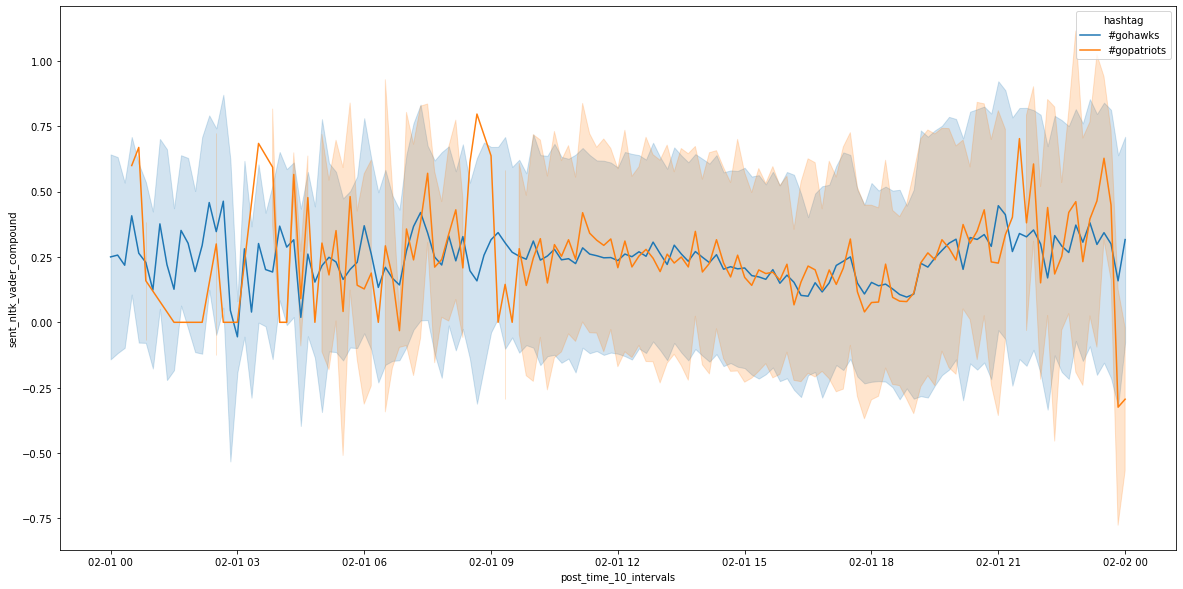

In [44]:
plt.figure(figsize=(20,10))
sns.lineplot(data=sub_df, x=time_inteerval_feature, y=sentiment_feature, hue='hashtag', ci='sd' )

<AxesSubplot:xlabel='post_time_10_intervals', ylabel='sent_nltk_vader_compound'>

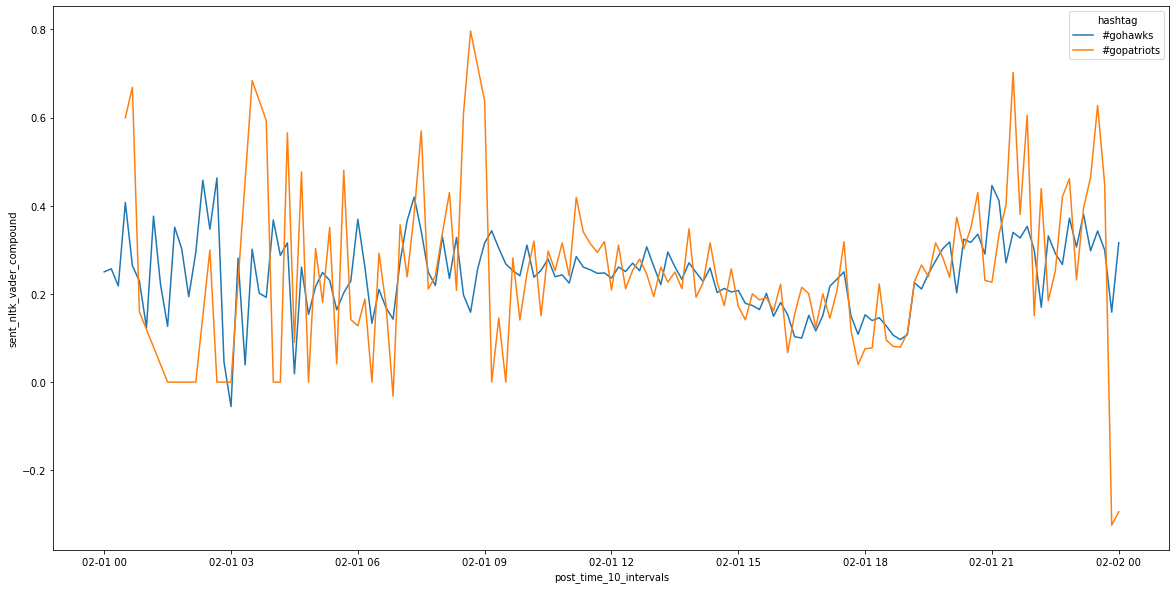

In [45]:
plt.figure(figsize=(20,10))
sns.lineplot(data =fan_sentiments_df, x=time_interval_feature, y=sentiment_feature, hue='hashtag', ci=None)

In [47]:
#pls =['Doug Baldwin', 'Dan Connolly', 'Tom Brady', 'Marshawn Lynch', 'Richard Sherman', 'Russell Wilson']

pls =['Tom Brady', 'Marshawn Lynch', 'Richard Sherman', 'Russell Wilson']


sub_df = tweet_emt_df[(tweet_emt_df.game_status=='during_game') &
                      (tweet_emt_df.player_count==1) &
                      (tweet_emt_df.players_str.isin(pls))]

fan_sentiments_df = pd.DataFrame(sub_df.groupby(by=[time_interval_feature,'hashtag','players_str'])[sentiment_feature].mean())
fan_sentiments_df.reset_index(inplace=True)
fan_sentiments_df

,post_time_10_intervals,hashtag,players_str,sent_nltk_vader_compound
0,2015-02-01 15:30:00-08:00,#gohawks,Marshawn Lynch,0.079489
1,2015-02-01 15:30:00-08:00,#gohawks,Richard Sherman,0.159743
2,2015-02-01 15:30:00-08:00,#gohawks,Russell Wilson,0.207300
3,2015-02-01 15:30:00-08:00,#gohawks,Tom Brady,-0.179155
4,2015-02-01 15:30:00-08:00,#gopatriots,Marshawn Lynch,0.538600
...,...,...,...,...
135,2015-02-01 19:00:00-08:00,#gopatriots,Russell Wilson,0.153000
136,2015-02-01 19:00:00-08:00,#gopatriots,Tom Brady,0.180704
137,2015-02-01 19:10:00-08:00,#gohawks,Marshawn Lynch,0.491400
138,2015-02-01 19:10:00-08:00,#gohawks,Tom Brady,-0.359500


<AxesSubplot:xlabel='post_time_10_intervals', ylabel='sent_nltk_vader_compound'>

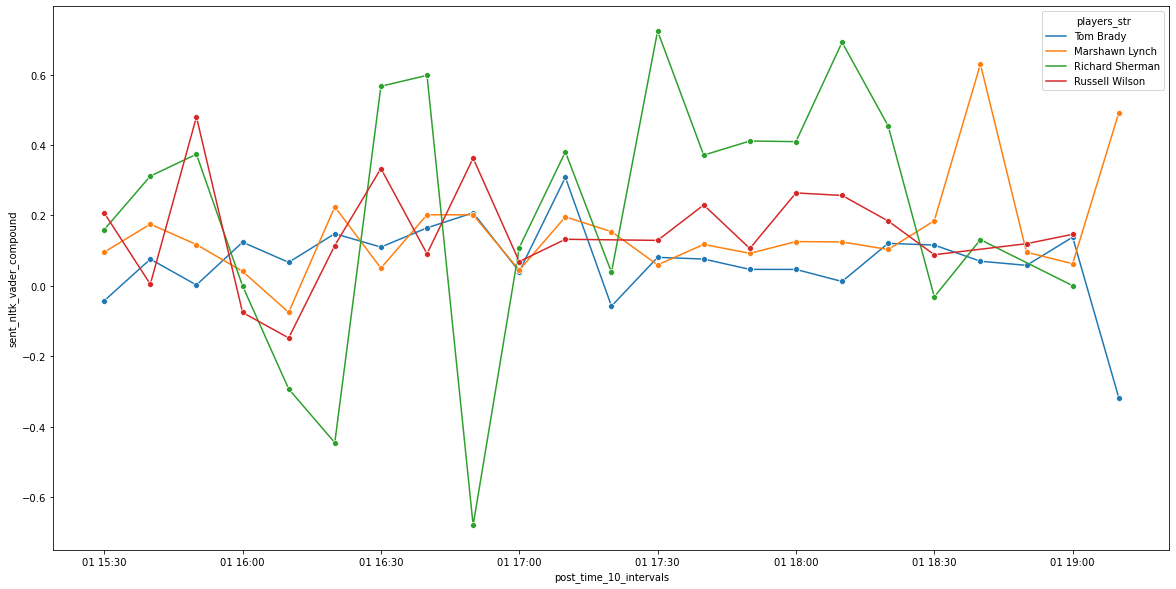

In [48]:
plt.figure(figsize=(20,10))
#fan_sentiments_df
sns.lineplot(data = sub_df, x=time_interval_feature, y=sentiment_feature, hue='players_str' , ci=None,  marker='o')

<AxesSubplot:xlabel='post_time_10_intervals', ylabel='sent_nltk_vader_compound'>

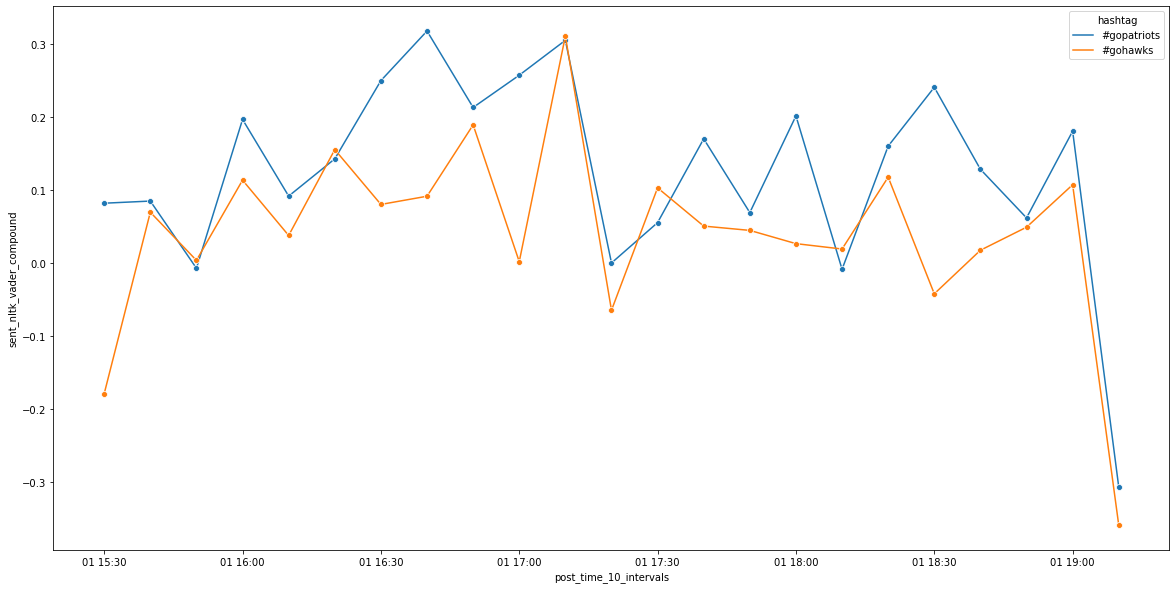

In [49]:
plt.figure(figsize=(20,10))

sbf= sub_df[sub_df.players_str=='Tom Brady']
sns.lineplot(data =sbf, x=time_interval_feature, #style='hashtag',
             y=sentiment_feature, hue='hashtag', ci=None, marker='o')

emotions, mentions, hashtags, user # follower, friends count --> predict retweet count, gavorit count, 

In [ ]:
# count, mention count. what predicts the impression of a tweet.
# given a tweet



# Creating labels based on time

One of the biggest challenge I had is to map the real time with the game time. Game scores and significant events data available on the internet is relative to the game time such as first touch down is happend in second quarter 9:47 (example: https://www.espn.com/nfl/playbyplay/_/gameId/400749027 check all plays and scoring plays table). However, tweets are based on real time. 

Unfortunately, game clock isn't kept counting down continuously during game. Even though game is considered 1 hour with each quarter 15 minutes, I realized that the actual game took generally 2-3 hours. In the superbowl 49 case, it took 3h 36 minutes as written on the internet. Hence, I need to find a way to map the game time and real time where tweets are written.

I tried several things:
- My first approach was to find timestamps of the game (either significant event or scores), but after hours of search it lead me nowhere. Even when I checked the full Youtube video of the gamee, I realized that the clip was shortened where halftime shows removed, so that didn't helped either on mapping the game time to real time.

- As a last resort, I decided to extract the score times from the tweets. I know the scores of the game, so with regex I searched the tweets where scores shared, and from those tweets I filtered and kept only the correct scores realized within the duration of the game (see scores_list). 

scores_list = ['7-0','7-7','14-7','14-14','14-17','14-24','21-24','28-24']

This is especially important because there are some tweets with prediction scores of the game. Also, according to american footbal rules, once touchdown happens a team gets 6 points and then with extras that score can increase up to 1 or 2 more points. Some tweets were posted without the extra points (ie 14-23) so scores_list helped me filter out those as well since I want to be consistent with the Scoring Plays results I dounf in espn website (https://www.espn.com/nfl/playbyplay/_/gameId/400749027). I also limited the post date of the tweets after game start time to make sure to get real scores. 

Then, my assumption is that if a user tweets the score, then it means there is a change in score and one of the team has scored. And I could use the relative real time of the score by taking the time of the earliest tweet posted with that score. In this way for each score, I can have a relative real tweet times in PST time where each score happened. Of course, the earliest tweet might be posted couple minutes later and might not be exact with the score time. But this is the best approximation and map I could get with the available data I have.

As a sanity check I also looked whether the found time frames fall in the relative place in the quarter the score happened. You can see the final dataframe with score and time mapping below:

TODO check quarters of the scores..

In [66]:
scores_list = ['7-0','7-7', '14-7','14-14','14-17','14-24','21-24','28-24']

# regex to find scores of the game written by users in the tweets
strs = r'(0|[1-9]\d*)-(0|[1-9]\d*)' #'(0|[1-9]\d*)-(0|[1-9]\d*)|(0|[1-9]\d*) - (0|[1-9]\d*)' #'touchdown|td|Touch down|Touchdown|TD'
sub_twt_df = tweet_emt_df[(tweet_emt_df['tweet.text'].str.contains(strs)) &
                          (tweet_emt_df['citation_date_fixed'] > GAME_START)] 

res = sub_twt_df['tweet.text'].str.extract(strs, expand=True)
res['score'] = res.apply(lambda x: str(x[0])+'-'+str(x[1]), axis=1)
res = res[res.score.isin(scores_list)]

sub_twt_df = pd.concat([sub_twt_df,res], axis=1)

cls = ['citation_date_fixed', 'score']
score_not_null = sub_twt_df[sub_twt_df.score.notnull()]
#display(score_not_null[cls])

score_time_df = score_not_null[cls].groupby(by=['score']).first()
score_time_df = score_time_df.reindex(scores_list)
score_time_df.reset_index(inplace=True)
def find_leading(score):
    scores = score.split('-')
    pat_score = int(scores[0])
    hawk_score = int(scores[1])
    leading=''
    if pat_score==hawk_score:
        leading='Tie' 
    elif pat_score > hawk_score:
        leading='Patriots'
    else:
        leading='Seahawks'
    return leading
score_time_df['leading']= score_time_df.score.apply(lambda x: find_leading(x))
start = pd.DataFrame([['0-0', GAME_START, 'Tie' ]], columns=['score', 'citation_date_fixed', 'leading'])
score_time_df = pd.concat([start, score_time_df])
score_time_df[time_interval_feature] = score_time_df['citation_date_fixed'].apply(lambda x: timeround(x, round_val=round_num))
display(score_time_df)

/Users/gorkemcamli/opt/anaconda3/envs/ece219_p4/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,score,citation_date_fixed,leading,post_time_2_intervals
0,0-0,2015-02-01 15:30:00-08:00,Tie,2015-02-01 15:30:00-08:00
0,7-0,2015-02-01 16:12:34-08:00,Patriots,2015-02-01 16:12:00-08:00
1,7-7,2015-02-01 16:33:56-08:00,Tie,2015-02-01 16:34:00-08:00
2,14-7,2015-02-01 16:48:33-08:00,Patriots,2015-02-01 16:48:00-08:00
3,14-14,2015-02-01 16:59:57-08:00,Tie,2015-02-01 17:00:00-08:00
4,14-17,2015-02-01 17:37:23-08:00,Seahawks,2015-02-01 17:38:00-08:00
5,14-24,2015-02-01 18:15:38-08:00,Seahawks,2015-02-01 18:16:00-08:00
6,21-24,2015-02-01 18:29:34-08:00,Seahawks,2015-02-01 18:30:00-08:00
7,28-24,2015-02-01 18:48:19-08:00,Patriots,2015-02-01 18:48:00-08:00


Next step is then assigning labels for each tweet: two columns created for each tweet 1- game score relative to when the tweet is posted and 2- who is leading the game (tie, seahawks, patriots) in the relative time of tweet posted. 


__How to Round the time__?
TODO explain


In [67]:
pls = list(players_df.Player)   #['Doug Baldwin', 'Dan Connolly', 'Tom Brady', 'Marshawn Lynch', 'Richard Sherman', 'Russell Wilson']

sub_df = tweet_emt_df[(tweet_emt_df.game_status=='during_game') &
                      (tweet_emt_df.player_count==1) &
                      (tweet_emt_df.players_str.isin(pls))]

fan_sentiments_df = pd.DataFrame(sub_df.groupby(by=[time_interval_feature,'hashtag','players_str'])[sentiment_feature].mean())
fan_sentiments_df.reset_index(inplace=True)
fan_sentiments_df

,post_time_2_intervals,hashtag,players_str,sent_textblob_polarity
0,2015-02-01 15:30:00-08:00,#gohawks,Earl Thomas,0.333333
1,2015-02-01 15:30:00-08:00,#gohawks,Kam Chancellor,0.000000
2,2015-02-01 15:30:00-08:00,#gohawks,Marshawn Lynch,0.125000
3,2015-02-01 15:30:00-08:00,#gohawks,Nate Solder,-0.050000
4,2015-02-01 15:30:00-08:00,#gohawks,Tom Brady,-0.166667
...,...,...,...,...
972,2015-02-01 19:04:00-08:00,#gopatriots,Tom Brady,-0.170139
973,2015-02-01 19:06:00-08:00,#gohawks,Earl Thomas,-0.066667
974,2015-02-01 19:06:00-08:00,#gohawks,Marshawn Lynch,0.047222
975,2015-02-01 19:06:00-08:00,#gohawks,Tom Brady,0.287500


In [68]:
model_data = fan_sentiments_df.pivot_table(columns ='players_str', index=[time_interval_feature], values=[sentiment_feature])
model_data.reset_index(inplace=True)
model_data = model_data.sort_values(by=[time_interval_feature])
model_data.columns = model_data.columns.droplevel(0)
model_data.rename(columns={'':time_interval_feature}, inplace=True)
model_data.head(3)

players_str,post_time_2_intervals,Bobby Wagner,Brandon Browner,Brandon LaFell,Bruce Irvin,Byron Maxwell,Chandler Jones,Cliff Avril,Dan Connolly,Darrelle Revis,...,Ricardo Lockette,Richard Sherman,Rob Gronkowski,Russell Wilson,Ryan Wendell,Sebastian Vollmer,Shane Vereen,Tom Brady,Tony McDaniel,Vince Wilfork
0,2015-02-01 15:30:00-08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,-0.073593,NaN,NaN
1,2015-02-01 15:32:00-08:00,NaN,NaN,NaN,0.0,NaN,-0.25,NaN,0.000000,NaN,...,NaN,-0.024167,NaN,-0.78125,NaN,NaN,NaN,0.010093,NaN,NaN
2,2015-02-01 15:34:00-08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000521,NaN,...,NaN,0.600000,NaN,0.00000,NaN,NaN,NaN,0.121349,0.0,NaN


In [69]:
def get_label(post_date):
    df = score_time_df[score_time_df[time_interval_feature] <= post_date]
    scr =  '' if df.empty else df.score.values[-1]
    lbl =  '' if df.empty else df.leading.values[-1]
    return [scr, lbl]

model_data[['score','leading']] = model_data.apply(lambda x: get_label(x[time_interval_feature]), axis=1, result_type='expand')
model_data

players_str,post_time_2_intervals,Bobby Wagner,Brandon Browner,Brandon LaFell,Bruce Irvin,Byron Maxwell,Chandler Jones,Cliff Avril,Dan Connolly,Darrelle Revis,...,Rob Gronkowski,Russell Wilson,Ryan Wendell,Sebastian Vollmer,Shane Vereen,Tom Brady,Tony McDaniel,Vince Wilfork,score,leading
0,2015-02-01 15:30:00-08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,-0.073593,NaN,NaN,0-0,Tie
1,2015-02-01 15:32:00-08:00,NaN,NaN,NaN,0.0,NaN,-0.25,NaN,0.000000,NaN,...,NaN,-0.781250,NaN,NaN,NaN,0.010093,NaN,NaN,0-0,Tie
2,2015-02-01 15:34:00-08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000521,NaN,...,NaN,0.000000,NaN,NaN,NaN,0.121349,0.0,NaN,0-0,Tie
3,2015-02-01 15:36:00-08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.346094,NaN,NaN,NaN,0.025463,NaN,NaN,0-0,Tie
4,2015-02-01 15:38:00-08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,...,NaN,0.000000,0.875,NaN,NaN,0.080556,NaN,NaN,0-0,Tie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,2015-02-01 18:58:00-08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.312500,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.017986,NaN,NaN,28-24,Patriots
105,2015-02-01 19:00:00-08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.083333,NaN,...,NaN,NaN,NaN,NaN,NaN,0.060278,NaN,NaN,28-24,Patriots
106,2015-02-01 19:02:00-08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.104861,NaN,NaN,-0.7,0.253479,NaN,NaN,28-24,Patriots
107,2015-02-01 19:04:00-08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.136364,NaN,NaN,NaN,-0.085069,NaN,NaN,28-24,Patriots


In [91]:
pls = [ 'Bobby Wagner', 'Brandon Browner',
       'Brandon LaFell', 'Bruce Irvin', 'Byron Maxwell', 'Chandler Jones',
       'Cliff Avril', 'Dan Connolly', 'Darrelle Revis', 'Devin McCourty',
       'Doug Baldwin', 'Earl Thomas', 'J.R. Sweezy', 'James Carpenter',
       'Jamie Collins', 'Jermaine Kearse', 'Julian Edelman', 'Justin Britt',
       'K.J. Wright', 'Kam Chancellor', 'Kevin Williams', 'Kyle Arrington',
       'Luke Willson', 'Marshawn Lynch', 'Max Unger', 'Michael Bennett',
       'Nate Solder', 'Patrick Chung', 'Ricardo Lockette', 'Richard Sherman',
       'Rob Gronkowski', 'Russell Wilson', 'Ryan Wendell', 'Sebastian Vollmer',
       'Shane Vereen', 'Tom Brady', 'Tony McDaniel', 'Vince Wilfork',]
X =  model_data[pls]
y = model_data['leading']

In [92]:
print(X.shape)
int_NA = int(0.3*X.shape[0])
print(int_NA)
X = X.dropna(thresh=int_NA, axis=1)
X.shape

(109, 38)
32


(109, 6)

In [93]:
X = X.fillna(0)
X.shape

(109, 6)

In [72]:
print(len(y))
y.value_counts(normalize=True)

109


Tie         0.431193
Seahawks    0.321101
Patriots    0.247706
Name: leading, dtype: float64

In [56]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [99]:
#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
#clf = LogisticRegression(random_state=0)
clf = RandomForestClassifier(n_estimators=400, max_depth=1,random_state=0, class_weight='balanced')
#clf = MLPClassifier(max_iter=500)
cv_results = evaluate(clf, X, y, cv=10)
#print(cv_results)
cv_results['test_score'].mean()

0.42181818181818176

In [58]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        return_train_score=True,
        return_estimator=True
    
        #scoring=["accuracy", "f1"],
    )
    #avg_acc = cv_results["test_mean_accuracy"]
    #avg_f1 = cv_results["test_mean_f1"]
    #print(avg_acc, avg_f1)
    #print(
    #    f"Mean Absolute Error:     {avg_acc:.3f} +/- {mae.std():.3f}\n"
    #    f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    #)
    return cv_results

In [593]:


ts_cv = TimeSeriesSplit(
    n_splits=105,
    gap=0,
    max_train_size=3,
    test_size=1,
)

#https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py

In [573]:
pd.DataFrame(y).T

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
leading,Tie,Tie,Tie,Tie,Tie,Tie,Tie,Tie,Tie,Tie,...,Seahawks,Patriots,Patriots,Patriots,Patriots,Patriots,Patriots,Patriots,Patriots,Patriots


In [658]:
#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
#clf = LogisticRegression(random_state=0)
clf = RandomForestClassifier(n_estimators=400, max_depth=1,random_state=0, class_weight='balanced')
#clf = MLPClassifier(max_iter=500)
cv_results = evaluate(clf, X, y, cv=10)
#print(cv_results)
cv_results['test_score'].mean()

0.5799999999999998

In [607]:
y.value_counts(normalize=True)

Tie         0.458716
Seahawks    0.321101
Patriots    0.220183
Name: leading, dtype: float64

In [579]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
all_splits

# delete splits where train same

[(array([1, 2, 3]), array([4])),
 (array([2, 3, 4]), array([5])),
 (array([3, 4, 5]), array([6])),
 (array([4, 5, 6]), array([7])),
 (array([5, 6, 7]), array([8])),
 (array([6, 7, 8]), array([9])),
 (array([7, 8, 9]), array([10])),
 (array([ 8,  9, 10]), array([11])),
 (array([ 9, 10, 11]), array([12])),
 (array([10, 11, 12]), array([13])),
 (array([11, 12, 13]), array([14])),
 (array([12, 13, 14]), array([15])),
 (array([13, 14, 15]), array([16])),
 (array([14, 15, 16]), array([17])),
 (array([15, 16, 17]), array([18])),
 (array([16, 17, 18]), array([19])),
 (array([17, 18, 19]), array([20])),
 (array([18, 19, 20]), array([21])),
 (array([19, 20, 21]), array([22])),
 (array([20, 21, 22]), array([23])),
 (array([21, 22, 23]), array([24])),
 (array([22, 23, 24]), array([25])),
 (array([23, 24, 25]), array([26])),
 (array([24, 25, 26]), array([27])),
 (array([25, 26, 27]), array([28])),
 (array([26, 27, 28]), array([29])),
 (array([27, 28, 29]), array([30])),
 (array([28, 29, 30]), array

In [248]:
# X.iloc[train_0]
# X.iloc[test_0]

In [505]:
y

0          Tie
1          Tie
2          Tie
3          Tie
4     Patriots
5     Patriots
6          Tie
7          Tie
8     Patriots
9          Tie
10         Tie
11         Tie
12         Tie
13    Seahawks
14    Seahawks
15    Seahawks
16    Seahawks
17    Seahawks
18    Seahawks
19    Seahawks
20    Patriots
21    Patriots
22    Patriots
Name: leading, dtype: object

In [570]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=4.0, max_depth=1, random_state=0)
cv_results = evaluate(clf, X, y, cv=ts_cv)
#print(cv_results)
cv_results['test_score'].mean()

/Users/gorkemcamli/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
6 fits failed out of a total of 35.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gorkemcamli/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gorkemcamli/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 497, in fit
    y = self._validate_y(y, sample_weight)
  File "/Users/gorkemcamli/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 1268, in _validate_y


nan

In [392]:
cv_results['estimator'][0].feature_impo

GradientBoostingClassifier(learning_rate=4.0, max_depth=1, random_state=0)

In [515]:
clf = LogisticRegression(random_state=0)
cv_results = evaluate(clf, X, y, cv=ts_cv)
#print(cv_results)
print(cv_results['test_score'].mean())
print(X.columns)
print(cv_results['estimator'][0].coef_)

nan
Index(['Dan Connolly', 'Earl Thomas', 'Jamie Collins', 'Julian Edelman',
       'Justin Britt', 'Kam Chancellor', 'Kevin Williams', 'Marshawn Lynch',
       'Nate Solder', 'Richard Sherman', 'Russell Wilson', 'Ryan Wendell',
       'Tom Brady'],
      dtype='object', name='players_str')
[[ 0.21705293 -0.01490791 -0.15416958 -0.27979171 -0.13495108  0.29015182
  -0.25077617  0.05871859  0.08071879  0.25886376  0.18389657  0.09427122
   0.01116446]]


/Users/gorkemcamli/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
7 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gorkemcamli/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gorkemcamli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1554, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'Tie'

-------------

In [500]:
clf = RandomForestClassifier(n_estimators=50, max_depth=10,random_state=0)
cv_results = evaluate(clf, X, y, cv=ts_cv)
#print(cv_results)
print(cv_results['test_score'].mean())
print(X.columns)
print(cv_results['estimator'][10].feature_importances_)

0.5
Index(['Dan Connolly', 'Earl Thomas', 'Jamie Collins', 'Julian Edelman',
       'Justin Britt', 'Kam Chancellor', 'Kevin Williams', 'Marshawn Lynch',
       'Nate Solder', 'Richard Sherman', 'Russell Wilson', 'Ryan Wendell',
       'Tom Brady'],
      dtype='object', name='players_str')
[0.06278555 0.06454509 0.08395751 0.06537171 0.06239344 0.12416161
 0.03039311 0.09038341 0.0610654  0.09484802 0.12253918 0.04208541
 0.09547057]


In [501]:
clf = MLPClassifier(hidden_layer_sizes=(100,),random_state=1, max_iter=300,  learning_rate_init=10.1,)
cv_results = evaluate(clf, X, y, cv=ts_cv)
#print(cv_results)
print(cv_results['test_score'].mean())
print(X.columns)
#print(cv_results['estimator'][10].feature_importances_)

0.4444444444444444
Index(['Dan Connolly', 'Earl Thomas', 'Jamie Collins', 'Julian Edelman',
       'Justin Britt', 'Kam Chancellor', 'Kevin Williams', 'Marshawn Lynch',
       'Nate Solder', 'Richard Sherman', 'Russell Wilson', 'Ryan Wendell',
       'Tom Brady'],
      dtype='object', name='players_str')


# Emojis -- not related for now.

__Are emojis all we need?__

How emojis used on tweets can be helpful on:
- Understanding sentiments/emotions of the fans during the game and for players?
    - nltk, emoji sentiments, bert
    
- Finding the most important times of the game? (emoji count vs time correlation, using emojis correlate score?, )
- Understanding reach/impressions/retweets of the game? (predict retweets, impressions and favs from the emoji information or vice versa.)
- can you tell mvp based on emoji count and emojis used.

Can an emoji tell more than 280 characters?

https://www.kaggle.com/eliasdabbas/emoji-data-descriptions-codepoints?select=emoji_df.csv
http://kt.ijs.si/data/Emoji_sentiment_ranking/index.html
https://pypi.org/project/emosent-py/
https://github.com/abushoeb/EmoTag/blob/master/data/EmoTag1200-scores-details.csv



In [64]:
def get_emoji_df(df):

    tweets = df.drop_duplicates().values.tolist()

    tweets  = [x for x in tweets if not x.startswith('RT')]

    
    try:
        # UCS-4
        e = re.compile(u'[\U00010000-\U0010ffff]')
    except re.error:
        # UCS-2
        e = re.compile(u'[\uD800-\uDBFF][\uDC00-\uDFFF]')

    emojis = []
    '''
    for i, x in enumerate(tweets):
        match  = e.search(x)
        if match:
            em_group = match.group()
            print(em_group, x, '\n')
            emojis.append(em_group)
    
    '''
    emoji_pattern = re.compile(u"(["                     # .* removed
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                                "])", flags= re.UNICODE)             # + removed

    for sent in tweets:
        emojis_found = ' '.join(re.findall(emoji_pattern, sent))
        #if emojis_found:
            #print(emojis_found, sent, '\n')
        emojis.append(emojis_found)

    dfe =  pd.DataFrame(emojis, columns=['emojis'])
    #display(pd.Series(' '.join(dfe['text']).lower().split()).value_counts()[:25])
    return dfe

x_df = get_emoji_df(df=tweet_dfs['gopatriots']['tweet.text'])
x_df['emoji_count'] = x_df['emojis'].apply(lambda x: len(x.split(' ')) if x else 0)
#x_df_hawks = get_emoji_df(df=tweet_dfs['gohawks']['title'])


# https://medium.com/swlh/%EF%B8%8Fdoes-emoji-use-correlate-with-twitter-engagement-388775467be

In [66]:
x_df[x_df.emoji_count!=0]

,emojis,emoji_count
1,😍 🙌 🏈 💙,4
7,🏈,1
10,😍 😍,2
12,👍,1
26,👊 🏈,2
...,...,...
22120,🏈 💋,2
22130,😂 😂 😂 🏈,4
22131,🏈 👊,2
22135,🏈,1


In [69]:
x_df_hawks = get_emoji_df(df=tweet_dfs['gohawks']['title'])
x_df_hawks['emoji_count'] = x_df_hawks['emojis'].apply(lambda x: len(x.split(' ')) if x else 0)
x_df_hawks[x_df_hawks.emoji_count!=0]

,emojis,emoji_count
10,💙 💚,2
11,😁,1
13,💙 💚,2
17,🌞,1
19,😎,1
...,...,...
162272,🏉 🏉 🏈 🏀 🎨 🎼 👑 🏰,8
162273,🎥 😜 😝 🏈 🏀 🏉 🎨 🎼 👑 🏰,10
162276,🎥 😜 😝 👀 🏈 🏀 🏉 🎨 🎼 👑 🏰,11
162283,😄 💖,2


In [78]:
emoji_counts = Counter(' '.join(x_df.emojis.tolist()).split(' '))
del emoji_counts['']
print(len(emoji_counts))
emoji_counts.most_common(30)

228


[('🏈', 2337),
 ('💙', 733),
 ('👏', 543),
 ('😂', 485),
 ('🙌', 381),
 ('🎉', 350),
 ('😍', 321),
 ('🏆', 238),
 ('💪', 212),
 ('🏉', 157),
 ('👊', 147),
 ('👍', 144),
 ('👌', 136),
 ('🇺', 134),
 ('🇸', 134),
 ('😁', 119),
 ('😭', 113),
 ('🙏', 112),
 ('😱', 77),
 ('😃', 74),
 ('😏', 64),
 ('😎', 63),
 ('😜', 62),
 ('😘', 60),
 ('😊', 60),
 ('🔵', 60),
 ('😄', 59),
 ('😉', 58),
 ('🎊', 56),
 ('🔴', 55)]

In [70]:
x_df_hawks.shape

(162309, 2)

In [29]:
tweet_dfs['gopatriots']

,firstpost_date,title,url,citation_date,highlight,type,citation_url,tweet.contributors,tweet.truncated,tweet.text,...,tweet.place.full_name,tweet.place.url,tweet.place.country,tweet.place.place_type,tweet.place.bounding_box.type,tweet.place.bounding_box.coordinates,tweet.place.country_code,tweet.place.id,tweet.place.name,tweet.place.bounding_box
0,1420835445,LeGarrette Blount does the Ray Lewis Dance #Th...,http://twitter.com/NESportsFan1106/status/5536...,1421257541,LeGarrette Blount does the Ray Lewis Dance #Th...,retweet:native,http://twitter.com/Patsnation87/status/5554205...,None,False,LeGarrette Blount does the Ray Lewis Dance #Th...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1420917552,Y así será mi futuro hijo 😍🙌❤🏈💙 #GoPatriots #M...,http://twitter.com/87patriots/status/553994483...,1421275471,Y así será mi futuro hijo 😍🙌❤🏈💙 #GoPatriots #M...,retweet:native,http://twitter.com/TheTruMD/status/55549570625...,None,False,Y así será mi futuro hijo 😍🙌❤🏈💙 #GoPatriots #M...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1420937045,With both my father and husband yelling at the...,http://twitter.com/meganwolfRD/status/55407624...,1421341875,With both my father and husband yelling at the...,retweet:native,http://twitter.com/Ricciardelli/status/5557742...,None,False,With both my father and husband yelling at the...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1421103502,The girls soccer team is ranked the No. 3 team...,http://twitter.com/AH__Athletics/status/554774...,1421285189,The girls soccer team is ranked the No. 3 team...,retweet:native,http://twitter.com/soccer44life10/status/55553...,None,False,The girls soccer team is ranked the No. 3 team...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1421109970,@patriots Patriots Champions! RT if you agree ...,http://twitter.com/joss_flacco/status/55480154...,1421427332,@patriots Patriots Champions! RT if you agree ...,retweet:native,http://twitter.com/DevaughnCaswell/status/5561...,None,False,@patriots Patriots Champions! RT if you agree ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23506,1423083356,Butler!!!! Yeess!!! Esto si que sería ganar so...,http://twitter.com/gustavoalohac10/status/5630...,1423083356,Butler!!!! Yeess!!! Esto si que sería ganar so...,tweet,http://twitter.com/gustavoalohac10/status/5630...,None,False,Butler!!!! Yeess!!! Esto si que sería ganar so...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23507,1423097475,Butler!!!! Yeess!!! Esto si que sería ganar so...,http://twitter.com/perla19camilaca/status/5631...,1423097475,Butler!!!! Yeess!!! Esto si que sería ganar so...,tweet,http://twitter.com/perla19camilaca/status/5631...,None,False,Butler!!!! Yeess!!! Esto si que sería ganar so...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23508,1423172815,#PatriotsNation sign petition to help sad peop...,http://twitter.com/DavidofSeattle/status/56345...,1423172815,#PatriotsNation sign petition to help sad peop...,tweet,http://twitter.com/DavidofSeattle/status/56345...,None,False,#PatriotsNation sign petition to help sad peop...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23509,1423228689,RT JomaGh: Comienza el #SUperBowl ¿A quien le ...,http://twitter.com/MikeInTownCUN/status/563688...,1423228689,RT JomaGh: Comienza el #SUperBowl ¿A quien le ...,tweet,http://twitter.com/MikeInTownCUN/status/563688...,None,False,RT JomaGh: Comienza el #SUperBowl ¿A quien le ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
tweet_dfs['gopatriots'].describe()

,firstpost_date,citation_date,tweet.in_reply_to_status_id,tweet.id,tweet.favorite_count,tweet.coordinates,tweet.in_reply_to_user_id,tweet.retweet_count,tweet.user.id,tweet.user.followers_count,...,metrics.citations.influential,metrics.citations.total,metrics.citations.matching,metrics.citations.replies,metrics.peak,metrics.impressions,metrics.momentum,author.influence_level,original_author.influence_level,tweet.place.bounding_box
count,2.351100e+04,2.351100e+04,2.179000e+03,2.351100e+04,23511.000000,0.0,3.036000e+03,23511.000000,2.351100e+04,2.351100e+04,...,23511.000000,23511.000000,23511.000000,23511.000000,2.351100e+04,2.351100e+04,23511.000000,11582.000000,11574.000000,0.0
mean,1.422581e+09,1.422582e+09,5.603311e+17,5.609733e+17,0.019608,NaN,4.840396e+08,0.026328,7.340778e+08,1.620572e+03,...,0.009017,1.408192,1.026243,0.007954,2.995076e+07,1.457090e+03,0.049721,1.783457,1.797650,NaN
std,4.755647e+05,4.753786e+05,2.786560e+15,1.994663e+15,0.466667,NaN,7.450373e+08,0.225048,9.183640e+08,2.925649e+04,...,0.107183,5.136899,0.518923,0.218412,2.042346e+08,2.672749e+04,0.749617,2.750998,2.766311,NaN
min,1.420835e+09,1.421229e+09,5.108709e+17,5.536501e+17,0.000000,NaN,5.244630e+05,0.000000,8.214240e+05,0.000000e+00,...,0.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,NaN
25%,1.422799e+09,1.422800e+09,5.579766e+17,5.618838e+17,0.000000,NaN,3.728424e+07,0.000000,9.844328e+07,8.100000e+01,...,0.000000,1.000000,1.000000,0.000000,0.000000e+00,8.000000e+01,0.000000,0.000000,0.000000,NaN
50%,1.422835e+09,1.422835e+09,5.619869e+17,5.620350e+17,0.000000,NaN,1.671555e+08,0.000000,3.028077e+08,2.140000e+02,...,0.000000,1.000000,1.000000,0.000000,0.000000e+00,2.120000e+02,0.000000,0.000000,0.000000,NaN
75%,1.422844e+09,1.422844e+09,5.620446e+17,5.620752e+17,0.000000,NaN,4.850827e+08,0.000000,9.614131e+08,5.030000e+02,...,0.000000,1.000000,1.000000,0.000000,0.000000e+00,4.985000e+02,0.000000,2.000000,2.000000,NaN
max,1.423296e+09,1.423296e+09,5.623125e+17,5.639691e+17,60.000000,NaN,3.006127e+09,14.000000,3.012591e+09,3.068313e+06,...,3.000000,379.000000,45.000000,22.000000,1.422926e+09,3.070686e+06,58.000000,10.000000,10.000000,NaN


In [9]:
#tweet_dfs['gopatriots'].profiling

In [17]:
tweet_dfs['gopatriots'][['tweet.truncated','highlight']]

,tweet.truncated,highlight
0,False,LeGarrette Blount does the Ray Lewis Dance #Th...
1,False,Y así será mi futuro hijo 😍🙌❤🏈💙 #GoPatriots #M...
2,False,With both my father and husband yelling at the...
3,False,The girls soccer team is ranked the No. 3 team...
4,False,@patriots Patriots Champions! RT if you agree ...
...,...,...
23506,False,Butler!!!! Yeess!!! Esto si que sería ganar so...
23507,False,Butler!!!! Yeess!!! Esto si que sería ganar so...
23508,False,#PatriotsNation sign petition to help sad peop...
23509,False,RT JomaGh: Comienza el #SUperBowl ¿A quien le ...


In [14]:
tweet_dfs['gopatriots'].title[0]

'LeGarrette Blount does the Ray Lewis Dance #ThrowbackThursday https://t.co/F5FX5KVmdX\nHope to see it at least 3 times tomorrow. \n#GoPatriots'

In [72]:
tweet_dfs['gopatriots']['metrics.impressions'].max()

3070686

In [25]:
tweet_dfs['gopatriots']['tweet.entities.hashtags'].describe()

count                                            23511
unique                                           12447
top       [{'indices': [0, 11], 'text': 'GoPatriots'}]
freq                                              1404
Name: tweet.entities.hashtags, dtype: object

In [49]:

df_cols = list(tweet_dfs['gopatriots'].columns)
selected_cols = [ col for col in df_cols if 'original_author' in col]
tweet_dfs['gopatriots'][selected_cols]

,original_author.author_img,original_author.description,original_author.url,original_author.nick,original_author.followers,original_author.image_url,original_author.type,original_author.name,original_author.influence_level
0,http://pbs.twimg.com/profile_images/5512012677...,Follow me for News on Boston Sports Teams! #G...,http://twitter.com/nesportsfan1106,nesportsfan1106,3811.0,http://pbs.twimg.com/profile_images/5512012677...,twitter,Boston Sports Fan,NaN
1,http://pbs.twimg.com/profile_images/5432108023...,My life: @Patriots ❤#PatriotsNation/ Celtics/R...,http://twitter.com/87patriots,87patriots,1163.0,http://pbs.twimg.com/profile_images/5432108023...,twitter,Mrs. Gronk,NaN
2,http://pbs.twimg.com/profile_images/4286917041...,a new york city nutritionist at megan wolf nut...,http://twitter.com/meganwolfrd,meganwolfrd,2124.0,http://pbs.twimg.com/profile_images/4286917041...,twitter,"megan wolf, ms rd",7.0
3,http://pbs.twimg.com/profile_images/5055340279...,Student run account covering \nAmerican Herita...,http://twitter.com/ah__athletics,ah__athletics,1216.0,http://pbs.twimg.com/profile_images/5055340279...,twitter,American Heritage,NaN
4,http://pbs.twimg.com/profile_images/5534009031...,"Soy esquizofrénico paranoide, que mola más que...",http://twitter.com/jossflacco,jossflacco,1165.0,http://pbs.twimg.com/profile_images/5534009031...,twitter,Necromancer.,0.0
...,...,...,...,...,...,...,...,...,...
23506,http://pbs.twimg.com/profile_images/5584087520...,Estudiante de periodismo en la Aficionado a la...,http://twitter.com/gustavoalohac10,gustavoalohac10,4.0,http://pbs.twimg.com/profile_images/5584087520...,twitter,Gustavo Rivera,NaN
23507,http://pbs.twimg.com/profile_images/5561924210...,? P?????? ? D??? ? N? S?? ? B???????? ? ? N?...,http://twitter.com/perla19camilaca,perla19camilaca,24.0,http://pbs.twimg.com/profile_images/5561924210...,twitter,Perla Calvo,NaN
23508,http://pbs.twimg.com/profile_images/5572943616...,"From Boston, but in Seattle via a 17 yr journe...",http://twitter.com/davidofseattle,davidofseattle,3459.0,http://pbs.twimg.com/profile_images/5572943616...,twitter,David Dallaire,1.0
23509,http://pbs.twimg.com/profile_images/5127646825...,Anuncios Clasificados Gratis Cancún | Asesor d...,http://twitter.com/mikeintowncun,mikeintowncun,854.0,http://pbs.twimg.com/profile_images/5127646825...,twitter,Anuncios Gratis CUN,1.0


In [144]:
player = 'Tom Brady'
tom_brady_text_df = tweet_dfs['gopatriots'][tweet_dfs['gopatriots']['title'].str.contains(player)]
tom_brady_text_df['len'] = tom_brady_text_df['title'].apply(lambda x: len(str(x)))

tom_brady_text_df['word_count'] = tom_brady_text_df['title'].apply(lambda x: len(x.split(' ')))
#tom_brady_text_df = tom_brady_text_df.sort_values(by=['metrics.citations.total'],ascending=False)
#tom_brady_text_df['word_cum_sum'] = tom_brady_text_df['word_count'].cumsum()
#tom_brady_text_df[['tweet.text','metrics.citations.total','len','word_count','word_cum_sum']]
tom_brady_text_df.shape

/var/folders/t3/qmdm09ls3m5352tkfm05z4hh0000gn/T/ipykernel_18054/256644787.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tom_brady_text_df['len'] = tom_brady_text_df['title'].apply(lambda x: len(str(x)))
/var/folders/t3/qmdm09ls3m5352tkfm05z4hh0000gn/T/ipykernel_18054/256644787.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tom_brady_text_df['word_count'] = tom_brady_text_df['title'].apply(lambda x: len(x.split(' ')))


(360, 12)

In [68]:
tom_brady_text_df[tom_brady_text_df['word_cum_sum']< 500].shape

(21, 120)

In [69]:
tom_brady_text_list= tom_brady_text_df.head(21)['tweet.text'].tolist()
tom_brady_text = '. '.join(tom_brady_text_list)
tom_brady_text

"It's SuperBowl Sunday 🏈 #Patriots vs #Seahawks Tom Brady vs Russell Wilson #SB49 #SuperBowlXLIX @NFL #NEvsSEA #GoPatriots #GoPats. I'm a Pats fan who loves Richard Sherman and Russell Wilson #truth #SuperBowlXLIX #GoPatriots. Even though Russell Wilson is from Richmond he still went to Collegiate... #GoPatriots. Can someone shut Russell Wilson up. He's so fake and unlikeable it's ridiculous. #gopatriots. Russell Wilson knows Revis Island is a dangerous place to visit. It's why he hasn't thrown that way. #GoPatriots. #patriots #GoPatriots Belichick 1/26: 'Russell Wilson is a winner' http://t.co/HT2tnb4TpF. Russell Wilson is the real MVP #gopatriots. I swear, w/ the exception of Russell Wilson....I can't stand the @Seahawks. &amp; I'm ecstatic that they loss! #GoPatriots 👍🏆🏈. If Russell Wilson doesn't pull this off, everyone at work will be upset! Hahaha #wearehuskies #GoPatriots #bradyistheman. I just can't take all the cheesy Russell Wilson quotes that would follow a Russell Wilson co

In [ ]:
# to do clean links, create a column contains link true. 